### SSR and FROLs (the greedy algorithms!) examples
There are many algorithms to solve the SINDy regression problem. SSR and FROLs are two popular greedy algorithms. Greedy algorithms iteratively truncate model coefficients, and search for the best model, based on some metric for success. These models work well in practice, but may have weak local convergence and may lack other algorithm guarantees. 

SSR algorithm based on Boninsegna, L., Nüske, F., & Clementi, C. (2018). Sparse learning of stochastic dynamical equations. The Journal of chemical physics, 148(24), 241723 and FROLS algorithm based on Billings, S. A. (2013). Nonlinear system identification: NARMAX methods in the time, frequency, and spatio-temporal domains. John Wiley & Sons.
Jupyter notebook written by Alan Kaptanoglu and Jared Callaham.

Stepwise sparse regression (SSR) solves the problem by iteratively truncating the smallest coefficient during the optimization. There are many ways one can decide to truncate terms. We implement two popular ways: (1) truncating the smallest coefficient at each iteration; (2) chopping each coefficient, computing N - 1 models, and then choosing the model with the lowest residual error.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error

import pysindy as ps
from pysindy.utils import lorenz

# Ignore odeint warnings when model is unstable
import warnings
warnings.filterwarnings("ignore")

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

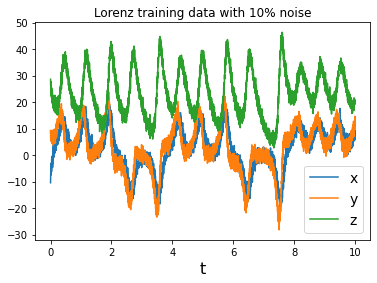

In [2]:
# Generate some training data with added gaussian noise
dt = .002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T
rmse = mean_squared_error(x_train, np.zeros((x_train).shape), squared=False)
x_train = x_train + np.random.normal(0, rmse / 10.0, x_train.shape)
feature_names = ['x', 'y', 'z']
                    
ssr_optimizer = ps.SSR()

model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

for i in range(3):
    plt.plot(t_train, x_train[:, i], label=feature_names[i])
    
plt.xlabel('t', fontsize=16)
plt.legend(fontsize=14)
plt.title('Lorenz training data with 10% noise')
plt.show()

### Define some functions for plotting performance as the greedy algorithms progress

In [3]:
import matplotlib.gridspec as gridspec

def plot_x_dot_fits(x_test, optimizer, dt, n_models):
    plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(x_test)  

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(x_test, t=dt)

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_dot_test_computed[:, i],
                        'k', label='numerical derivative')
            plt.plot(t_test, x_dot_test_predicted[:, i],
                        'r', label='model prediction')
            if j == 0:
                plt.ylabel('$\dot ' + feature_names[i] + r'$', fontsize=20)
            if i == 0:
                plt.title('MSE = %.0f' % model.score(x_test, t=dt, metric=mean_squared_error), fontsize=16)
            plt.xlabel('Iteration ' + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        model.print()     
        print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))
    ax.set_yticklabels([])
    plt.show()

    
def plot_x_fits(x_test, t_test, optimizer, n_models):
    plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Simulate dynamic system with the identified model
        # Some of these models may diverge, so need to use odeint (which just gives a warning)
        # rather than the default solve_ivp, which crashes with an error
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator='odeint')

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_test[:, i], 'k', label='test trajectory')
            if np.max(np.abs(x_test_sim[:, i])) < 1000:  # check for unstable systems
                plt.plot(t_test, x_test_sim[:, i], 'r', label='model prediction')
            if j == 0:
                plt.ylabel(feature_names[i], fontsize=20)
            if i == 0:
                plt.title('MSE = %.0f' % model.score(x_test, t=dt, metric=mean_squared_error), fontsize=16)
            plt.xlabel('Iteration ' + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)
   
        print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))
    ax.set_yticklabels([])
    plt.show()

### Note that the usage is a bit different because we save all the sparse models and we choose our favorite one afterwards. Below we show that we can track the MSE between the predicted and true derivative on a testing trajectory as the algorithm iterates, and then choose the model with the minimum MSE. 

(x0)' = -38.830 1 + 0.891 x0 + 2.063 x1 + 3.944 x2 + 0.458 x0^2 + -0.534 x0 x1 + -0.293 x0 x2 + 0.167 x1^2 + 0.219 x1 x2 + -0.105 x2^2
(x1)' = 16.764 1 + 16.338 x0 + 4.746 x1 + -1.666 x2 + 0.024 x0^2 + -0.115 x0 x1 + -0.697 x0 x2 + 0.054 x1^2 + -0.125 x1 x2 + 0.041 x2^2
(x2)' = 30.539 1 + -7.913 x0 + 5.688 x1 + -6.593 x2 + -0.532 x0^2 + 1.144 x0 x1 + 0.247 x0 x2 + 0.089 x1^2 + -0.186 x1 x2 + 0.129 x2^2
Model 0, MSE: 89.130046
(x0)' = 2.664 1 + 1.181 x0 + 2.528 x1 + -0.442 x2 + 0.248 x0^2 + -0.389 x0 x1 + -0.293 x0 x2 + 0.161 x1^2 + 0.199 x1 x2
(x1)' = 17.628 1 + 16.348 x0 + 4.745 x1 + -1.776 x2 + -0.090 x0 x1 + -0.697 x0 x2 + 0.047 x1^2 + -0.125 x1 x2 + 0.044 x2^2
(x2)' = 31.734 1 + -8.211 x0 + 5.734 x1 + -6.586 x2 + -0.604 x0^2 + 1.309 x0 x1 + 0.250 x0 x2 + -0.183 x1 x2 + 0.130 x2^2
Model 1, MSE: 84.906742
(x0)' = 4.096 1 + 0.636 x0 + 2.603 x1 + -0.353 x2 + 0.123 x0^2 + -0.095 x0 x1 + -0.287 x0 x2 + 0.205 x1 x2
(x1)' = -2.923 1 + 16.226 x0 + 4.455 x1 + 0.297 x2 + -0.043 x0 x1 + -0.700

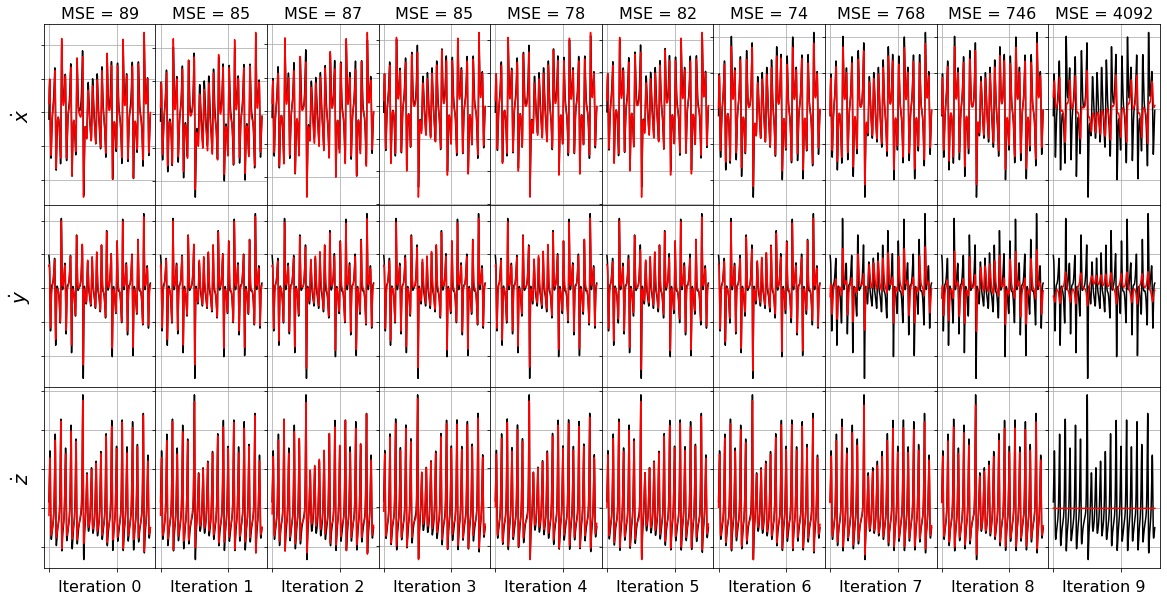

In [4]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords).y.T
n_models = 10
plot_x_dot_fits(x_test, ssr_optimizer, dt, n_models)

Model 0, MSE: 89.130046
Model 1, MSE: 84.906742
Model 2, MSE: 87.239089
Model 3, MSE: 84.623665
Model 4, MSE: 77.975551
Model 5, MSE: 82.255454
Model 6, MSE: 74.475569
Model 7, MSE: 768.379565
Model 8, MSE: 745.981192
Model 9, MSE: 4091.579799


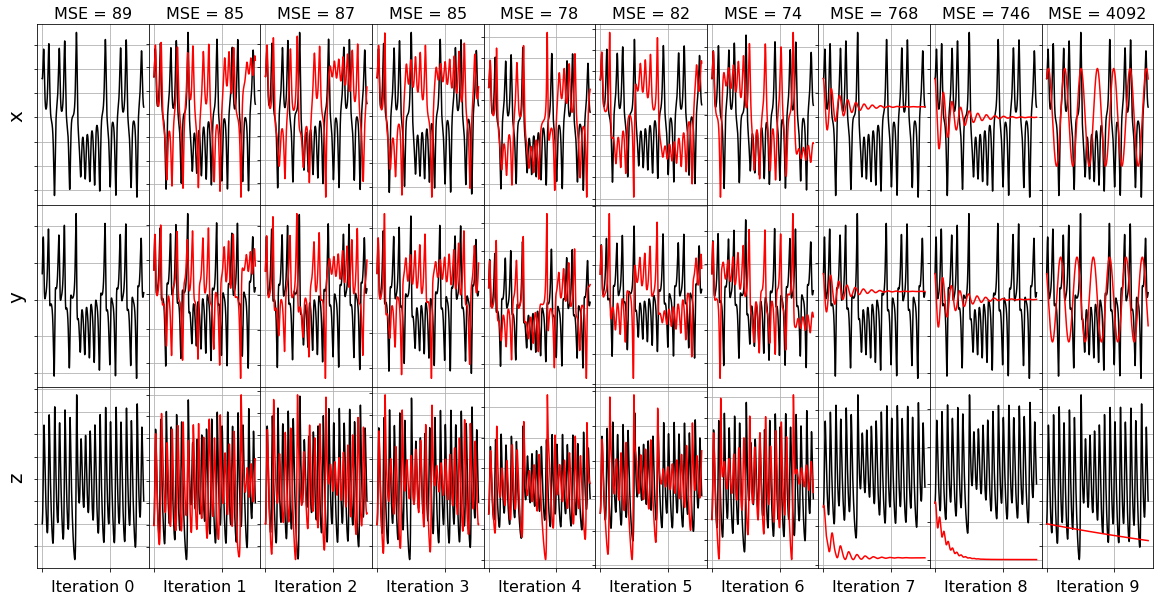

In [5]:
# Repeat plots but now integrate the ODE and compare the test trajectories
plot_x_fits(x_test, t_test, ssr_optimizer, n_models)

Note that some of the frames do not have any red lines... that means the model for this iteration resulted in an unstable model when it was integrated forward. This often happens with nonsparse models!

# Repeat the SSR fitting with the lowest model residual method

In [6]:
ssr_optimizer2 = ps.SSR(criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optimizer2)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=SSR(criteria='model_residual'))

(x0)' = -38.830 1 + 0.891 x0 + 2.063 x1 + 3.944 x2 + 0.458 x0^2 + -0.534 x0 x1 + -0.293 x0 x2 + 0.167 x1^2 + 0.219 x1 x2 + -0.105 x2^2
(x1)' = 16.764 1 + 16.338 x0 + 4.746 x1 + -1.666 x2 + 0.024 x0^2 + -0.115 x0 x1 + -0.697 x0 x2 + 0.054 x1^2 + -0.125 x1 x2 + 0.041 x2^2
(x2)' = 30.539 1 + -7.913 x0 + 5.688 x1 + -6.593 x2 + -0.532 x0^2 + 1.144 x0 x1 + 0.247 x0 x2 + 0.089 x1^2 + -0.186 x1 x2 + 0.129 x2^2
Model 0, MSE: 89.130046
(x0)' = -38.787 1 + 2.587 x1 + 3.961 x2 + 0.459 x0^2 + -0.530 x0 x1 + -0.267 x0 x2 + 0.164 x1^2 + 0.203 x1 x2 + -0.105 x2^2
(x1)' = 17.628 1 + 16.348 x0 + 4.745 x1 + -1.776 x2 + -0.090 x0 x1 + -0.697 x0 x2 + 0.047 x1^2 + -0.125 x1 x2 + 0.044 x2^2
(x2)' = 31.734 1 + -8.211 x0 + 5.734 x1 + -6.586 x2 + -0.604 x0^2 + 1.309 x0 x1 + 0.250 x0 x2 + -0.183 x1 x2 + 0.130 x2^2
Model 1, MSE: 83.959348
(x0)' = -36.547 1 + 2.346 x1 + 3.959 x2 + 0.325 x0^2 + -0.227 x0 x1 + -0.277 x0 x2 + 0.219 x1 x2 + -0.103 x2^2
(x1)' = 16.618 1 + 16.117 x0 + 4.780 x1 + -1.536 x2 + -0.028 x0 x1

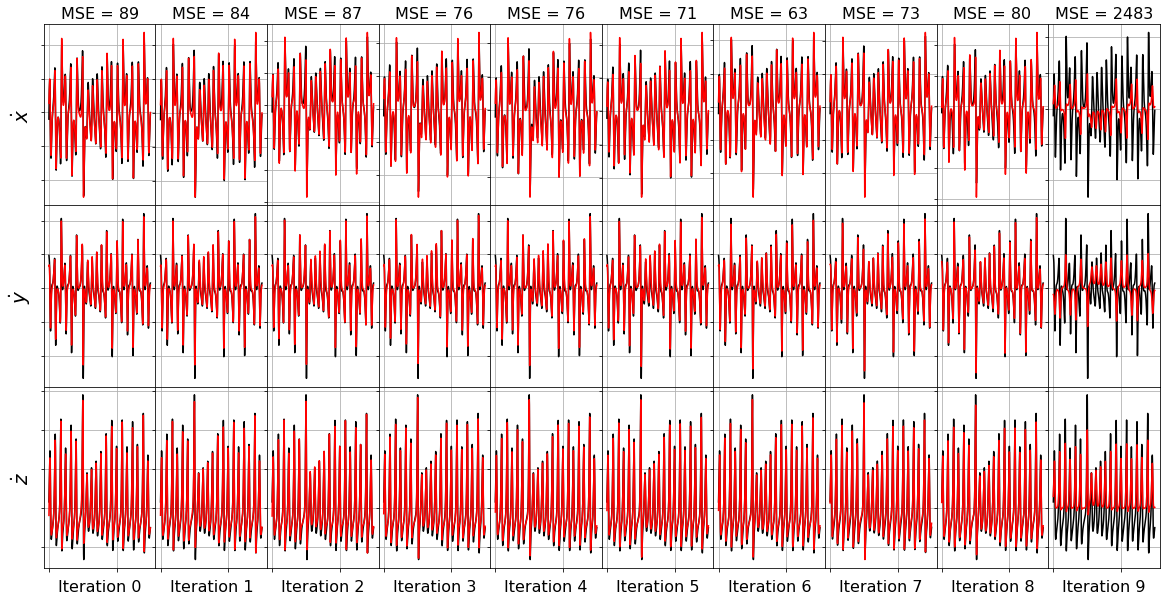

In [7]:
plot_x_dot_fits(x_test, ssr_optimizer2, dt, n_models)

Model 0, MSE: 89.130046
Model 1, MSE: 83.959348
Model 2, MSE: 86.630689
Model 3, MSE: 75.849759
Model 4, MSE: 76.265009
Model 5, MSE: 71.093839
Model 6, MSE: 62.919002
Model 7, MSE: 72.939936
Model 8, MSE: 80.494510
Model 9, MSE: 2483.178727


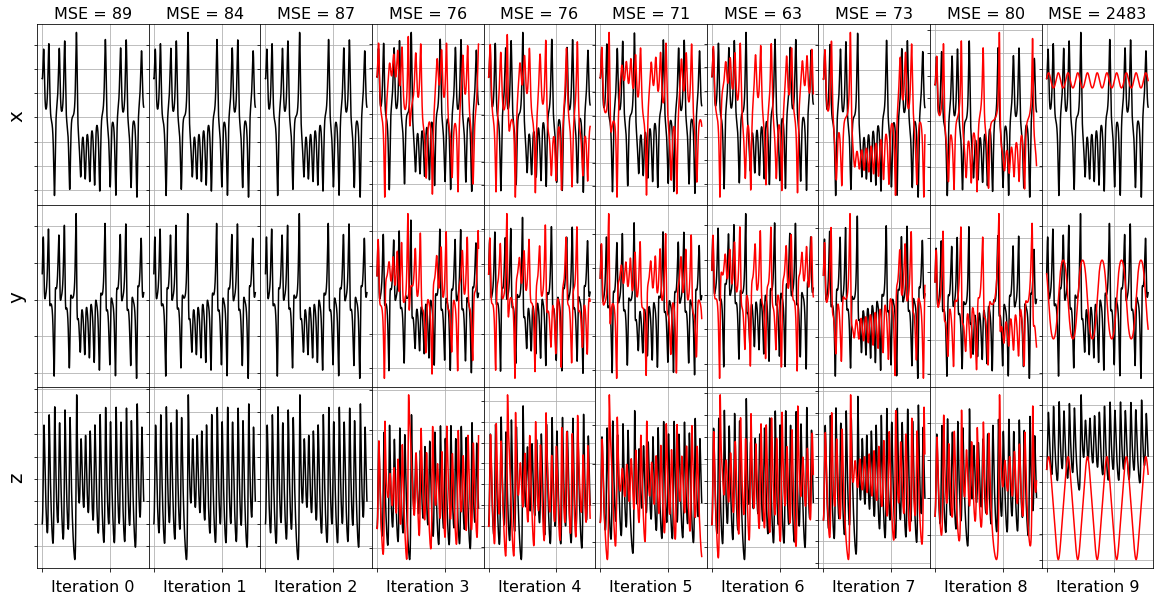

In [8]:
plot_x_fits(x_test, t_test, ssr_optimizer2, n_models)

# FROLS greedy algorithm
Forward Regression Orthogonal Least Squares (FROLS) solves the least-squares regression problem with $L_0$ norm by iteratively selecting the most correlated function in the library. At each step, the candidate functions are orthogonalized with respect to the already-selected functions. The selection criteria is the Error Reduction Ratio, i.e. the normalized increase in the explained output variance due to the addition of a given function to the basis.
### Note that (at least our implementation) performs poorly on noise, generating more unstable models than SSR. FROLs is also different from FROLs because it starts with no coefficients and then at each iteration adds a new nonzero coefficient.

In [9]:
frols_optimizer = ps.FROLS()

model = ps.SINDy(optimizer=frols_optimizer)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=FROLS())

(x0)' = 0.000
(x1)' = 0.000
(x2)' = 0.000
Model 0, MSE: 4453.379931
(x0)' = 2.174 x1
(x1)' = -0.148 x0 x2
(x2)' = 0.389 x1^2
Model 1, MSE: 2382.164200
(x0)' = -7.886 x0 + 7.773 x1
(x1)' = 21.851 x0 + -0.801 x0 x2
(x2)' = -50.796 1 + 0.597 x1^2
Model 2, MSE: 268.435326
(x0)' = 1.207 x0 + 6.205 x1 + -0.258 x0 x2
(x1)' = 15.535 x0 + 3.001 x1 + -0.691 x0 x2
(x2)' = -29.199 1 + -5.394 x0 x1 + 4.171 x1^2
Model 3, MSE: 8251.406554
(x0)' = 0.094 x0 + 0.216 x1 + -0.297 x0 x2 + 0.321 x1 x2
(x1)' = 9.129 x0 + 10.059 x1 + -0.453 x0 x2 + -0.301 x1 x2
(x2)' = -0.556 1 + -2.407 x2 + 0.546 x0 x1 + 0.262 x1^2
Model 4, MSE: 138.076775
(x0)' = -2.086 1 + 0.098 x0 + 0.216 x1 + -0.295 x0 x2 + 0.323 x1 x2
(x1)' = 1.194 x0 + 2.115 x1 + -0.528 x0 x2 + 0.032 x1 x2 + 0.306 x2^2
(x2)' = -0.397 1 + -2.535 x2 + 0.122 x0^2 + 0.416 x0 x1 + 0.298 x1^2
Model 5, MSE: 21324.522758
(x0)' = -0.009 1 + 0.099 x0 + 0.215 x1 + -0.037 x0 x1 + -0.294 x0 x2 + 0.323 x1 x2
(x1)' = 1.187 x0 + 2.103 x1 + 0.076 x0 x1 + -0.526 x0 x2 +

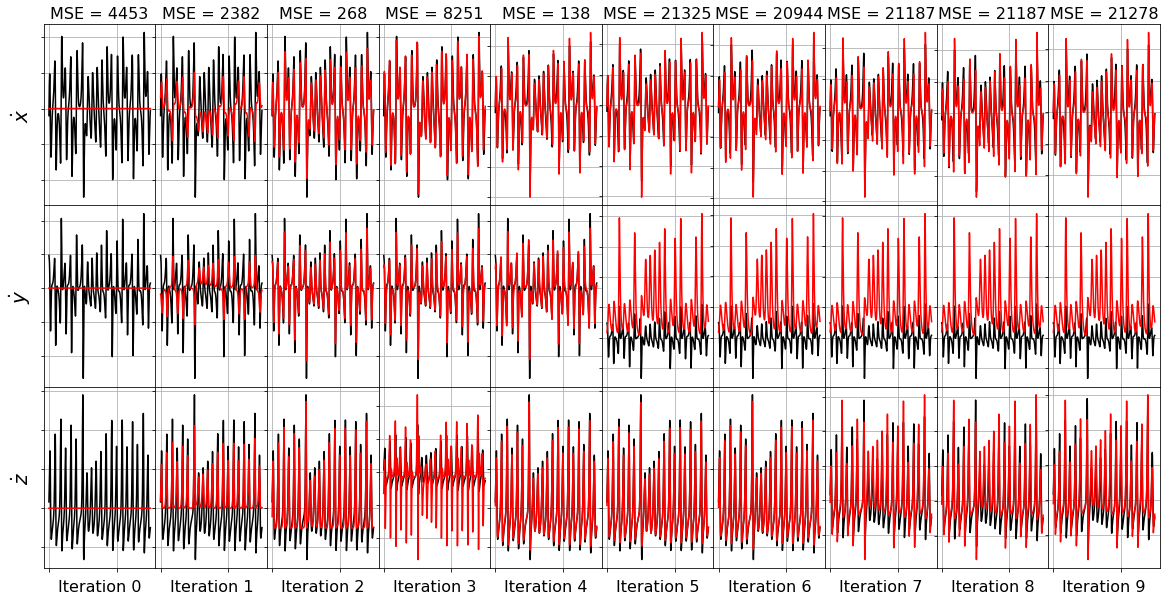

In [10]:
plot_x_dot_fits(x_test, frols_optimizer, dt, n_models)

Model 0, MSE: 4453.379931
Model 1, MSE: 2382.164200
Model 2, MSE: 268.435326
Model 3, MSE: 8251.406554
Model 4, MSE: 138.076775
Model 5, MSE: 21324.522758
Model 6, MSE: 20944.423511
Model 7, MSE: 21187.015882
Model 8, MSE: 21187.108742
Model 9, MSE: 21278.452743


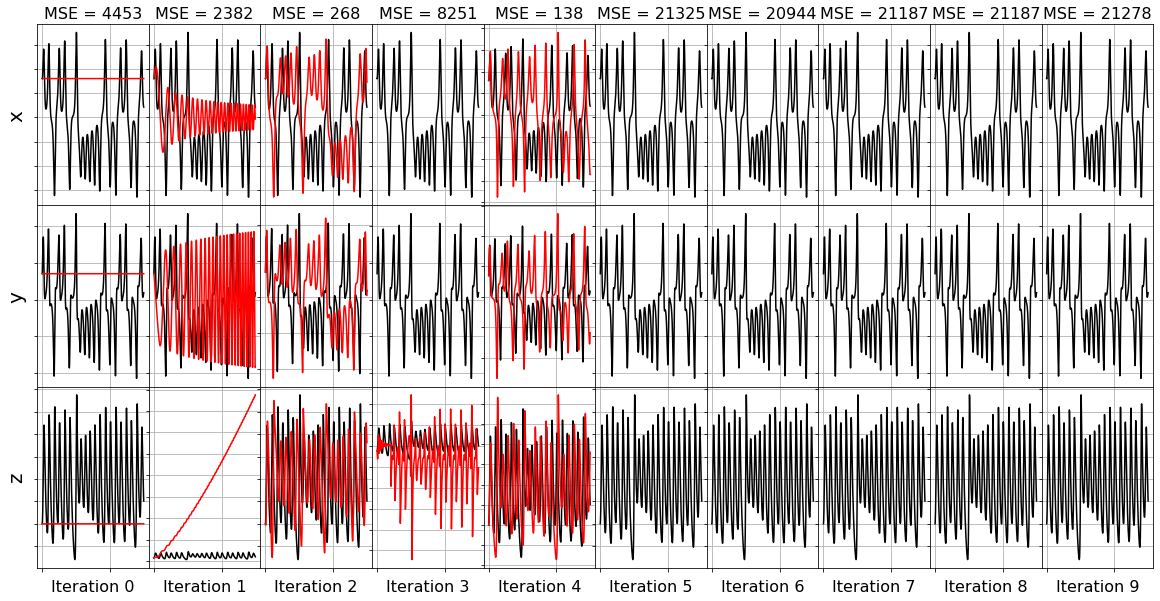

In [11]:
plot_x_fits(x_test, t_test, frols_optimizer, n_models)

### Let's compare all three methods as the noise steadily increases, cross-validated over 10 noise instantiations

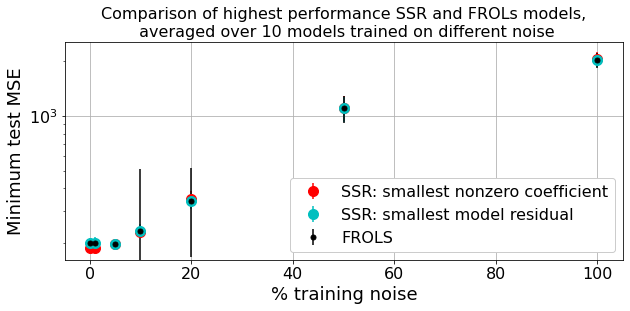

In [12]:
# generate training and testing data
dt = .1
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T
rmse = mean_squared_error(x_train, np.zeros((x_train).shape), squared=False)
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords).y.T

# Cross-validate over 10 discharges for each noise level
n_validation = 10
noise_levels = [rmse / 1000.0, rmse / 100.0, rmse / 20.0, 
                rmse / 10.0, rmse / 5.0, rmse / 2.0, rmse]
criterias = ["coefficient_value", "model_residual"]
final_MSE = np.zeros((3, len(noise_levels), n_validation))
for k, noise_level in enumerate(noise_levels):
    for i in range(n_validation):
        x_noisy = x_train + np.random.normal(0, noise_level, x_train.shape)
        for kk in range(3): 
            if kk == 0:
                optimizer = ps.SSR(criteria="coefficient_value")
            if kk == 1:
                optimizer = ps.SSR(criteria="model_residual")
            if kk == 2:
                optimizer = ps.FROLS()
            model = ps.SINDy(optimizer=optimizer)
            model.fit(x_noisy, t=dt)
            MSE = np.zeros(np.shape(optimizer.history_)[0])
            for j in range(np.shape(optimizer.history_)[0]):
                optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]
                MSE[j] = model.score(x_test, t=dt, metric=mean_squared_error)
            final_MSE[kk, k, i] = np.min(MSE)
            
average_MSE_cross_validated = np.mean(final_MSE, axis=-1)
std_MSE_cross_validated = np.std(final_MSE, axis=-1)

# Plot average MSE results with error bars.
# Note we are not including a sparsity penalty in the error term.
plt.figure(figsize=(10, 4))
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[0, :], 
             yerr=std_MSE_cross_validated[0, :], fmt='o', color='r', markersize=10,
             label='SSR: smallest nonzero coefficient')
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[1, :], fmt='o', color='c', markersize=10,
             label='SSR: smallest model residual')
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[2, :], fmt='o', color='k', markersize=5,
             label='FROLS')
plt.yscale('log')
plt.legend(fontsize=16, loc='lower right', framealpha=1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
plt.xlabel('% training noise', fontsize=18)
plt.ylabel('Minimum test MSE', fontsize=18)
plt.title('Comparison of highest performance SSR and FROLs models,\n '
          'averaged over 10 models trained on different noise', fontsize=16)
plt.savefig('SSR_FROLS_comparison.png')

### Summary
To summarize the findings here, SSR seems to substantially outperform FROLs, at least on this noisy and chaotic data. The "best model" (as measured by the minimal MSE on a testing trajectory) for FROLs often competes with the SSR "best model", but usually with much higher variance. Moreover, almost all the SSR models outperform the FROLs models at the same level of sparsity! So we strongly recommend that on noisy, chaotic data, one uses STLSQ or SSR. The advantage of using SSR is that no hyperparameters are necessarily needed, although one has to choose a favorite or best model at the end. 